In [1]:
import sys
sys.path.append('/home/jovyan/farsite-devAPI/src/')
sys.path.append('/home/jovyan/python-helper/src/')

import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import MultiPolygon, Polygon

import uuid
import random
import datetime

import farsiteutils_v2 as futils
from kalmanutils import calculate_uncertainties_observed, interpolate_perimeter

from loggers import TimeEstimator

from matplotlib import pyplot as plt

In [2]:
def calculate_max_area_geom(multigeom):
    max_area = 0
    max_area_idx = 0
    for ix, g in enumerate(multigeom.geoms):
        if g.area > max_area:
            max_area = g.area
            max_area_idx = ix
    return multigeom.geoms[max_area_idx]

In [3]:
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

In [4]:
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

Database interaction not yet implemented. Use pickle file for dataframes instead!


### Run 30-minute simulations at a fixed windspeed and direction : ws=10, wd=90

In [5]:
def calculate(igniteidx, compareidx, usr, windspeed = 10, winddirection = 90):
    lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
    barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index

    # Generate df for the next reference ignition only to get the datetime
    filetype = 'Ignition'
    # objectid = str(usr.db.gdfignition.loc[igniteidx, 'objectid']) + '_simRef'
    filepath = f'/home/jovyan/farsite/inputs/maria_ignite/maria_{compareidx}'
    comparedatetime = usr.db.gdfignition.loc[igniteidx, 'datetime'] + datetime.timedelta(minutes=30)
    description = SELECTED_FIRE_DEFAULT

    gdfcompare = gpd.GeoDataFrame(index=[compareidx], data = {'filetype': filetype,
                                          'objectid': '21231_RefTruth',
                                          'filepath': filepath,
                                          'datetime': comparedatetime,
                                          'description': description,
                                          'geometry': None})

    usr.db.gdfignition = pd.concat([usr.db.gdfignition, gdfcompare])

    inputData = {'description': description,
                 'igniteidx'  : igniteidx,
                 'compareidx' : compareidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr.calculatePerimeters(inputData)
    mainapi.run_farsite()

    # Collect the simulated geometry
    gdfsim = usr.db.gdfsimulation.iloc[-1]
    gdfsim_geom = gdfsim['geometry']
    if isinstance(gdfsim_geom, MultiPolygon):
        gdfsim_geom = calculate_max_area_geom(gdfsim_geom)

    # Update the ignition table with the simulated info
    usr.db.gdfignition.loc[compareidx, 'filepath'] = usr.db.gdfsimulation.iloc[-1]['filepath']
    usr.db.gdfignition.loc[compareidx, 'geometry'] = gdfsim_geom
    
    gpd.GeoDataFrame({'FID': [0], 'geometry':gdfsim_geom}, 
                 crs='EPSG:5070').to_file(gdfsim['filepath'])

In [6]:
igniteidx_lst = [usr.db.gdfignition.index[0]] + [uuid.uuid4().hex for i in range(12)]

In [7]:
for i in range(len(igniteidx_lst[:-1])):
    print('\n---------------------------------')
    print(f'Calculating {i}/{len(igniteidx_lst)}')
    calculate(igniteidx_lst[i], igniteidx_lst[i+1], usr, windspeed = 10, winddirection = 90)


---------------------------------
Calculating 0/13
{'description': 'Maria2019', 'igniteidx': 'f23196b034474744bdca7df94b13e0f7', 'compareidx': '51fdaebe31f44ad69272779a3f01182d', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00000/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21231.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00000/out

---------------------------------


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00001/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230203/Run_00000/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00001/out

---------------------------------
Calculating 2/13
{'description': 'Maria2019', 'igniteidx': '68b265e5ba78410d9ba23e595c4ebe4d', 'compareidx': 'aab698d3dcdb40c5a200fa962062eac6', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00002/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230203/Run_00001/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00002/out

---------------------------------
Calculating 3/13
{'description': 'Maria2019', 'igniteidx': 'aab698d3dcdb40c5a200fa962062eac6', 'compareidx': '898b0f9313d44e70bfe3fd53a269981f', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00003/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230203/Run_00002/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00003/out

---------------------------------
Calculating 4/13
{'description': 'Maria2019', 'igniteidx': '898b0f9313d44e70bfe3fd53a269981f', 'compareidx': 'f812b5bd6b9841c7a9d3c049f2ef65d0', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00004/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230203/Run_00003/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00004/out

---------------------------------
Calculating 5/13
{'description': 'Maria2019', 'igniteidx': 'f812b5bd6b9841c7a9d3c049f2ef65d0', 'compareidx': '1902f9bb87654d6596616ce39baa5bd4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00005/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230203/Run_00004/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00005/out

---------------------------------
Calculating 6/13
{'description': 'Maria2019', 'igniteidx': '1902f9bb87654d6596616ce39baa5bd4', 'compareidx': '8a431825f5ed4c80a5c8bbe6272aae75', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00006/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230203/Run_00005/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00006/out

---------------------------------
Calculating 7/13
{'description': 'Maria2019', 'igniteidx': '8a431825f5ed4c80a5c8bbe6272aae75', 'compareidx': 'eaf6ac2e01c14ee6a7575004cc255470', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00007/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230203/Run_00006/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00007/out

---------------------------------
Calculating 8/13
{'description': 'Maria2019', 'igniteidx': 'eaf6ac2e01c14ee6a7575004cc255470', 'compareidx': '2a2d3f9489a34a5ebe7acb1842be28b9', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00008/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230203/Run_00007/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00008/out

---------------------------------
Calculating 9/13
{'description': 'Maria2019', 'igniteidx': '2a2d3f9489a34a5ebe7acb1842be28b9', 'compareidx': 'a966c3e028054453ae6ae791bdbb2eaa', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00009/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230203/Run_00008/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00009/out

---------------------------------
Calculating 10/13
{'description': 'Maria2019', 'igniteidx': 'a966c3e028054453ae6ae791bdbb2eaa', 'compareidx': '4589feb89833462392177adc46d432b2', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00010/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230203/Run_00009/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00010/out

---------------------------------
Calculating 11/13
{'description': 'Maria2019', 'igniteidx': '4589feb89833462392177adc46d432b2', 'compareidx': 'b93e051584c54d3183511baf8088fc84', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230203/Run_00011/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230203/Run_00010/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 18)
Writing outputs for Farsite #1 to /home/jovyan/data/20230203/Run_00011/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


In [8]:
def plot_geometry(geom, ax, **kwargs):
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)

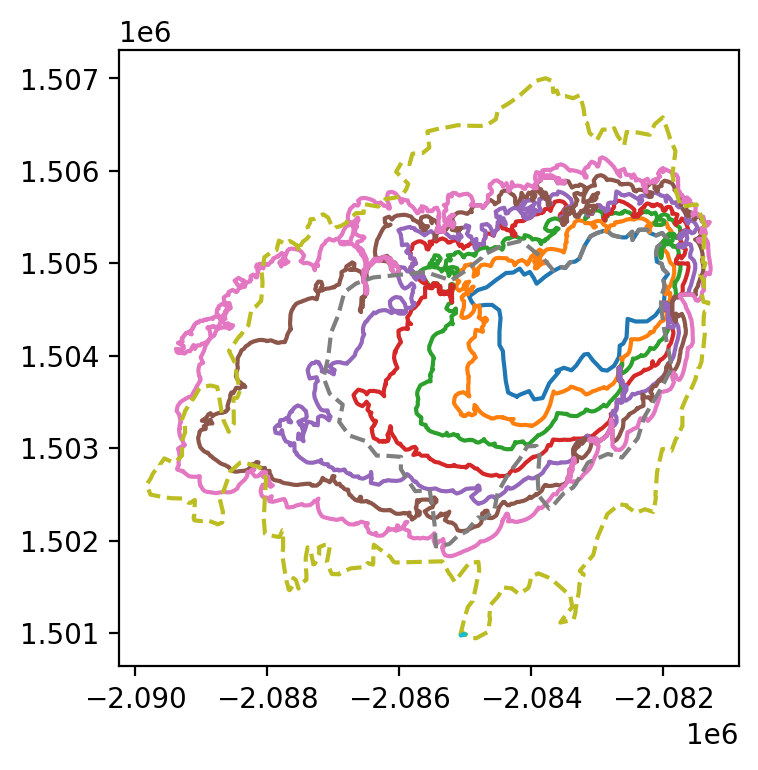

In [9]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

for igniteidx in igniteidx_lst[::2]:
    plot_geometry(usr.db.gdfignition.loc[igniteidx, 'geometry'], ax=ax)
    
plot_geometry(usr.db.gdfignition.iloc[2]['geometry'], ax=ax, ls='--')
plot_geometry(usr.db.gdfignition.iloc[5]['geometry'], ax=ax, ls='--')

In [10]:
pd.concat([pd.read_pickle(fp.dfpath), usr.db.gdfignition[usr.db.gdfignition['objectid'].isna()]]).to_pickle('/home/jovyan/data/test_table_ref.pkl')
# pd.read_pickle('/home/jovyan/data/test_table_ref.pkl')